In [1]:
!pip install torchaudio transformers datasets jiwer


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\jared\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


From Task 2d, you are to use the common-voice mp3 files under cv-valid-train and cv-valid-train.csv for finetuning train dataset. Write a python jupyter notebook called cv-train-2a.ipynb for this task, using either TensorFlow or PyTorch. You are to split the dataset into 70-30 ratio where 30% is kept for training validation. You are to list down your explanation for your chosen preprocessing, tokenizer, feature extraction and pipeline processes (including hyperparameters selected). You are also required to visualise the training and validation metrics and explain your
interpretation of these visualisations.

In [73]:
import os
import re
import torch
import random
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import torchaudio
from datasets import load_dataset, load_metric, Audio, load_from_disk
import numpy as np

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
# Define paths
AUDIO_DIR = r"C:\Users\jared\Downloads\common_voice\cv-valid-train"
CSV_FILE = r"C:\Users\jared\Downloads\common_voice\cv-valid-train.csv"

Justication for Tokenizer: 
- wav2vec2-base-960h is pre-trained on a massive dataset of 960 hours of speech data from LibriSpeech. This extensive training provides the model with a strong foundation in understanding the nuances of spoken language, including phoneme and word-level representations.
- Starting with a pre-trained model allows to leverage the power of transfer learning. Fine-tuning the pre-trained model on the specific dataset requires less training data and computational resources compared to training a model from scratch.

Justication for Feature Extractor: 
- The Wav2Vec2 processor wraps a feature extractor and a tokenizer into a single processor, offering all the functionalities both. It takes care of both feature extraction from audio and text label preparation, streamlining the data preprocessing pipeline.

In [5]:
# Load Wav2Vec2 model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# Create processor pipeline (Feature extractor built into processor)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:752: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `W

# 1. Data Processing

- cv-valid-train contains almost 200K files (195,776)
- With respect to compute power contraints, random subset of cv-valid-train data is then used, which is then further split into 70-30 train-validation
- Subset was then randomly selected as 20K records (20K/200K = 10%) among dataset, which is justifiably a decent subsample of the dataset  

In [78]:
# Load dataset from CSV
df = pd.read_csv(CSV_FILE)
df

filename  \
0       cv-valid-train/sample-000000.mp3   
1       cv-valid-train/sample-000001.mp3   
2       cv-valid-train/sample-000002.mp3   
3       cv-valid-train/sample-000003.mp3   
4       cv-valid-train/sample-000004.mp3   
...                                  ...   
195771  cv-valid-train/sample-195771.mp3   
195772  cv-valid-train/sample-195772.mp3   
195773  cv-valid-train/sample-195773.mp3   
195774  cv-valid-train/sample-195774.mp3   
195775  cv-valid-train/sample-195775.mp3   

                                                     text  up_votes  \
0       learn to recognize omens and follow them the o...         1   
1              everything in the universe evolved he said         1   
2       you came so that you could learn about your dr...         1   
3       so now i fear nothing because it was those ome...         1   
4       if you start your emails with greetings let me...         3   
...                                                   ...       ...   
195771                        the englishman said nothing         1   
195772                       the irish man sipped his tea         1   
195773                        what do you know about that         1   
195774                 the phone rang while she was awake         2   
195775  among these people were a couple of cyclists a...         4   

        down_votes       age gender   accent  duration  
0                0       NaN    NaN      NaN       NaN  
1                0       NaN    NaN      NaN       NaN  
2                0       NaN    NaN      NaN       NaN  
3                0       NaN    NaN      NaN       NaN  
4                2       NaN    NaN      NaN       NaN  
...            ...       ...    ...      ...       ...  
195771           0  thirties   male  england       NaN  
195772           0       NaN    NaN      NaN       NaN  
195773           0       NaN    NaN      NaN       NaN  
195774           0  twenties   male       us       NaN  
195775           1       NaN    NaN      NaN       NaN  

[195776 rows x 8 columns]

In [79]:
subset_df = df.sample(20000, replace=False, random_state=42)
subset_df

filename  \
182715  cv-valid-train/sample-182715.mp3   
114956  cv-valid-train/sample-114956.mp3   
139880  cv-valid-train/sample-139880.mp3   
34538   cv-valid-train/sample-034538.mp3   
142907  cv-valid-train/sample-142907.mp3   
...                                  ...   
115399  cv-valid-train/sample-115399.mp3   
118095  cv-valid-train/sample-118095.mp3   
84886   cv-valid-train/sample-084886.mp3   
135792  cv-valid-train/sample-135792.mp3   
39598   cv-valid-train/sample-039598.mp3   

                                                     text  up_votes  \
182715  the fine manufacturing company was a bookkeepe...         2   
114956  the mixture took on a reddish color almost the...         1   
139880                                enough said the boy         1   
34538   then he sat in the sunfilled doorway smoking t...         2   
142907  i've just guaranteed the bank sufficient funds...         1   
...                                                   ...       ...   
115399                              what's she saying now         1   
118095                        would you like a cappuccino         3   
84886                 how come you speak spanish he asked         1   
135792    it's a man who understands nature and the world         1   
39598   but none of that is from the pyramids said the...         2   

        down_votes       age  gender   accent  duration  
182715           0       NaN     NaN      NaN       NaN  
114956           0  fourties    male  england       NaN  
139880           0       NaN     NaN      NaN       NaN  
34538            1       NaN     NaN      NaN       NaN  
142907           0       NaN     NaN      NaN       NaN  
...            ...       ...     ...      ...       ...  
115399           0       NaN     NaN      NaN       NaN  
118095           0       NaN     NaN      NaN       NaN  
84886            0       NaN     NaN      NaN       NaN  
135792           0       NaN     NaN      NaN       NaN  
39598            0  thirties  female       us       NaN  

[20000 rows x 8 columns]

In [80]:
listnames = subset_df["filename"]
listnames

182715    cv-valid-train/sample-182715.mp3
114956    cv-valid-train/sample-114956.mp3
139880    cv-valid-train/sample-139880.mp3
34538     cv-valid-train/sample-034538.mp3
142907    cv-valid-train/sample-142907.mp3
                        ...               
115399    cv-valid-train/sample-115399.mp3
118095    cv-valid-train/sample-118095.mp3
84886     cv-valid-train/sample-084886.mp3
135792    cv-valid-train/sample-135792.mp3
39598     cv-valid-train/sample-039598.mp3
Name: filename, Length: 20000, dtype: object

In [ ]:
# Create an empty dataframe
df = pd.DataFrame() 
df["filename"] = subset_df["filename"]
df["text"] = subset_df["text"]
df

filename  \
182715  cv-valid-train/sample-182715.mp3   
114956  cv-valid-train/sample-114956.mp3   
139880  cv-valid-train/sample-139880.mp3   
34538   cv-valid-train/sample-034538.mp3   
142907  cv-valid-train/sample-142907.mp3   
...                                  ...   
115399  cv-valid-train/sample-115399.mp3   
118095  cv-valid-train/sample-118095.mp3   
84886   cv-valid-train/sample-084886.mp3   
135792  cv-valid-train/sample-135792.mp3   
39598   cv-valid-train/sample-039598.mp3   

                                                     text  
182715  the fine manufacturing company was a bookkeepe...  
114956  the mixture took on a reddish color almost the...  
139880                                enough said the boy  
34538   then he sat in the sunfilled doorway smoking t...  
142907  i've just guaranteed the bank sufficient funds...  
...                                                   ...  
115399                              what's she saying now  
118095                        would you like a cappuccino  
84886                 how come you speak spanish he asked  
135792    it's a man who understands nature and the world  
39598   but none of that is from the pyramids said the...  

[20000 rows x 2 columns]

Justification for Preprocessing:
- Resampling to Consistent Rate: The Wav2Vec2ForCTC model expects input audio with a specific sampling rate (e.g., 16000 Hz).Inconsistent sampling rates can degrade model performance. Resampling ensures uniform input to the model, leading to more stable and accurate training.

In [82]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def preprocess_audio(audio_dir, filename):    
    print(audio_dir)
    print(filename)
    full_path = os.path.join(audio_dir, filename) 
    print(f"Loading audio from: {full_path}")  # Print the full path
    try:
        audio, sample_rate = librosa.load(full_path, sr=16000) 
        print(audio)
        print(sample_rate)
        
        # Checking if resampling if necessary
        if sample_rate != 16000:
            audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000) 
        
    except Exception as e:
        print("Failed to transcribe audio" + str(e))

    return audio

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).upper()
    return batch

def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio, sampling_rate=16000).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [83]:
df['audio'] = df['filename'].map(lambda x: preprocess_audio(AUDIO_DIR, x))
df

C:\Users\jared\Downloads\common_voice\cv-valid-train
cv-valid-train/sample-182715.mp3
Loading audio from: C:\Users\jared\Downloads\common_voice\cv-valid-train\cv-valid-train/sample-182715.mp3
[-3.6379788e-12  0.0000000e+00 -1.2005330e-10 ... -5.9861486e-07
 -3.9429142e-06  5.4371776e-07]
16000
C:\Users\jared\Downloads\common_voice\cv-valid-train
cv-valid-train/sample-114956.mp3
Loading audio from: C:\Users\jared\Downloads\common_voice\cv-valid-train\cv-valid-train/sample-114956.mp3
[-4.0745363e-10  2.4010660e-10  2.5829650e-10 ...  6.1576290e-04
 -1.3944821e-03  1.4715064e-03]
16000
C:\Users\jared\Downloads\common_voice\cv-valid-train
cv-valid-train/sample-139880.mp3
Loading audio from: C:\Users\jared\Downloads\common_voice\cv-valid-train\cv-valid-train/sample-139880.mp3
[ 2.9103830e-11 -2.9103830e-10 -1.1641532e-10 ...  2.4302640e-04
  4.4746994e-04  6.0218768e-05]
16000
C:\Users\jared\Downloads\common_voice\cv-valid-train
cv-valid-train/sample-034538.mp3
Loading audio from: C:\Users\

filename  \
182715  cv-valid-train/sample-182715.mp3   
114956  cv-valid-train/sample-114956.mp3   
139880  cv-valid-train/sample-139880.mp3   
34538   cv-valid-train/sample-034538.mp3   
142907  cv-valid-train/sample-142907.mp3   
...                                  ...   
115399  cv-valid-train/sample-115399.mp3   
118095  cv-valid-train/sample-118095.mp3   
84886   cv-valid-train/sample-084886.mp3   
135792  cv-valid-train/sample-135792.mp3   
39598   cv-valid-train/sample-039598.mp3   

                                                     text  \
182715  the fine manufacturing company was a bookkeepe...   
114956  the mixture took on a reddish color almost the...   
139880                                enough said the boy   
34538   then he sat in the sunfilled doorway smoking t...   
142907  i've just guaranteed the bank sufficient funds...   
...                                                   ...   
115399                              what's she saying now   
118095                        would you like a cappuccino   
84886                 how come you speak spanish he asked   
135792    it's a man who understands nature and the world   
39598   but none of that is from the pyramids said the...   

                                                    audio  
182715  [-3.637979e-12, 0.0, -1.200533e-10, -1.4551915...  
114956  [-4.0745363e-10, 2.401066e-10, 2.582965e-10, 6...  
139880  [2.910383e-11, -2.910383e-10, -1.1641532e-10, ...  
34538   [-2.5465852e-11, 7.2759576e-11, -3.274181e-11,...  
142907  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                   ...  
115399  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
118095  [6.82121e-13, -7.275958e-12, -3.8653525e-12, -...  
84886   [7.275958e-12, -4.0017767e-11, -4.638423e-11, ...  
135792  [-1.0753348e-23, 3.970467e-23, 3.5568766e-23, ...  
39598   [2.3874236e-12, 2.2737368e-13, 4.3201e-12, 2.9...  

[20000 rows x 3 columns]

In [ ]:
# Convert the pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df) 
dataset = dataset.map(remove_special_characters)
dataset = dataset.map(prepare_dataset) 

In [ ]:
# applying train-test split of 70-30 to split train-val sets
dataset = dataset.train_test_split(test_size=0.3, seed=42)

Storing dataset to disk then loading from there as a progress checkpoint, since earlier code took a long time to run. 

In [18]:
dataset.save_to_disk("dataset_new") 

Saving the dataset (0/17 shards):   0%|          | 0/14000 [00:00<?, ? examples/s]

Saving the dataset (0/7 shards):   0%|          | 0/6000 [00:00<?, ? examples/s]

# 2. Model Development

In [6]:
dataset = load_from_disk("dataset_new") 

dataset

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'audio', '__index_level_0__', 'input_values', 'labels'],
        num_rows: 14000
    })
    test: Dataset({
        features: ['filename', 'text', 'audio', '__index_level_0__', 'input_values', 'labels'],
        num_rows: 6000
    })
})

Custom data collator is beneficial in some situations, like towards Advanced Padding Strategies if more control over padding is needed. In this situation, the replacement padding is done with -100 to ignore loss correctly.

In [7]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # Replacing padding with -100 so as to correctly ignore loss 
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [8]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [9]:
total_params = 0

for name, param in model.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape}") 
    total_params += torch.prod(torch.tensor(param.shape)).item() 

print(f"Total number of parameters: {total_params}")
print(f"Model size (approximately): {total_params * 4 / (1024 * 1024):.2f} MB") 

Layer: wav2vec2.masked_spec_embed | Shape: torch.Size([768])
Layer: wav2vec2.feature_extractor.conv_layers.0.conv.weight | Shape: torch.Size([512, 1, 10])
Layer: wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight | Shape: torch.Size([512])
Layer: wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias | Shape: torch.Size([512])
Layer: wav2vec2.feature_extractor.conv_layers.1.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.2.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.3.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.4.conv.weight | Shape: torch.Size([512, 512, 3])
Layer: wav2vec2.feature_extractor.conv_layers.5.conv.weight | Shape: torch.Size([512, 512, 2])
Layer: wav2vec2.feature_extractor.conv_layers.6.conv.weight | Shape: torch.Size([512, 512, 2])
Layer: wav2vec2.feature_projection.layer_norm.weight | Shape: torch.Size([512])
Layer: wav2

In [10]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

Model Development Rationale:
1. Freezing feature extractor: Unfreezing it to fine-tune the entire model for potentially better performance effectively is "fine-tuning from scratch". However, freezing the feature extractor is a common and effective strategy for fine-tuning pre-trained models like Wav2Vec2. It allows for faster training, improved stability, and better generalization, especially when dealing with limited training data. Notably, freezing the feature extractor effectively leverages transfer learning. The model benefits from the pre-trained knowledge of the feature extractor, allowing it to learn the specific task (e.g., speech recognition) more quickly and effectively.

In [11]:
model.freeze_feature_extractor()

C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [12]:
# Initialize counters
unfrozen_params = 0
frozen_params = 0

# Check which parameters are modified and are unfreezed
for name, param in model.named_parameters():
    if param.requires_grad:
        unfrozen_params += torch.prod(torch.tensor(param.shape)).item() 
    else:
        frozen_params += torch.prod(torch.tensor(param.shape)).item()

total_params = frozen_params + unfrozen_params
frozen_params_percentage = (frozen_params / total_params) * 100
unfrozen_params_percentage = (unfrozen_params / total_params) * 100

print(f"Total number of parameters: {total_params}")
print(f"Number of frozen parameters: {frozen_params} ({frozen_params_percentage:.2f}%)")
print(f"Number of unfrozen parameters: {unfrozen_params} ({unfrozen_params_percentage:.2f}%)") 

Total number of parameters: 94396320
Number of frozen parameters: 4200448 (4.45%)
Number of unfrozen parameters: 90195872 (95.55%)


WER is a widely accepted and standardized metric in the speech recognition field. This allows for consistent comparison of different ASR systems and research findings across the community. 
WER quantifies the number of errors made by the ASR system in transcribing speech. It also directly reflects how well the system aligns with human speech.
As such, we use WER as the desired metric for this task.

In [13]:
wer_metric = load_metric("wer")

C:\Users\jared\AppData\Local\Temp\ipykernel_10332\24688115.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [14]:
def compute_metrics(pred):
  pred_logits = pred.predictions
  pred_ids = np.argmax(pred_logits, axis=-1)
  # Padding replacement with -100 so as to correctly compute metrics
  pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

  # Decode predictions and references
  pred_str = processor.batch_decode(pred_ids)
  label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

  # Calculate WER as metric 
  wer = wer_metric.compute(predictions=pred_str, references=label_str)

  return {"wer": wer}

Hyperparameters Rationale:
- Batch size: Since batch sizes are commonly exponents of 2, knowing that the dataset for training has been sub-sampled to 2K with 70-30 split, a batch size of 32 is then selected as it allows for sufficient training across the provided training data.
- Learning rate: 1e-4 is a common starting learning rate for fine-tuning pre-trained language models. However, knowing that the model has already been pre-trained on a large dataset and the aim is to fine-tune towards a custom dataset, the learning rate is thereby reduced slightly to 1e-5.
- Max steps: It allows control over the training time and computational resources more effectively; by defining a fixed number of training steps, it is more convenient and reliable than relying solely on the number of epochs. max_steps of 100 is then selected as a balance of sufficient model training plus time efficiency given limited computational resources.

Note: GPU functions (eg, fp16=True) have been omitted for this assessment as local device used does not support CUDA :( 

In [15]:
training_args = TrainingArguments(
    output_dir="./results", 
    num_train_epochs=1,
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,  
    max_steps=100,
    save_steps=100,
    eval_steps=100,
    logging_steps=50,
    learning_rate=1e-5,
    warmup_steps=100, 
    report_to=["tensorboard"]
)

In [16]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


In [17]:
# trainer.train()

Clarification: By right this is the procedure to fine-tune an ASR model ideally with GPUs, but the above trainer is taking 6-7H per epoch on local device.

Due to computing limitations, the following revisions are made:
- Batch sizes reduced to 8 (Original Batch size of 32 leads to one epoch being ~1H, for numerous epochs this would take a while)
- Randomly sub-sample K from validation set of 600 records; arguably this is bad practice due to risks of data leakage and overfitting, however in interests of resource constraints, K records are randomly selected to form the validation set as to observe metrics during model training; K=32 was eventually selected   

In [18]:
training_args_v2 = TrainingArguments(
    output_dir="./results", 
    num_train_epochs=1,
    per_device_train_batch_size=8,  # reduced from 32 
    per_device_eval_batch_size=8,  # reduced from 32
    evaluation_strategy="steps",
    max_steps=100,
    save_steps=20,
    eval_steps=20,
    logging_steps=20,
    learning_rate=1e-5,
    report_to=["tensorboard"]
)

PyTorch: setting up devices


In [19]:
# Define the number of samples for each evaluation subset
num_eval_samples = 32 
eval_results = []

# Randomly select indices for the evaluation subset
for i in range(num_eval_samples):
    random_indices = random.sample(range(len(dataset["test"])), num_eval_samples) 
    val_subset = dataset["test"].select(random_indices) 

val_subset

Dataset({
    features: ['filename', 'text', 'audio', '__index_level_0__', 'input_values', 'labels'],
    num_rows: 32
})

In [20]:
trainer_v2 = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args_v2,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=val_subset,    # replced from dataset["test"]
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


In [21]:
trainer_v2.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: filename, audio, text, __index_level_0__. If filename, audio, text, __index_level_0__ are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 90195872


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: filename, audio, text, __index_level_0__. If filename, audio, text, __index_level_0__ are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 32
  Batch size = 8


{'loss': 263.0024, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.01}


  0%|          | 0/4 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-20
Configuration saved in ./results\checkpoint-20\config.json


{'eval_loss': 183.49293518066406, 'eval_wer': 0.15030674846625766, 'eval_runtime': 30.8891, 'eval_samples_per_second': 1.036, 'eval_steps_per_second': 0.129, 'epoch': 0.01}


Model weights saved in ./results\checkpoint-20\pytorch_model.bin
Feature extractor saved in ./results\checkpoint-20\preprocessor_config.json
C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: filename, audio, text, __index_level_0__. If filename, audio, text, __index_level_0__ are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 32
  Batch size = 8


{'loss': 209.1323, 'learning_rate': 6e-06, 'epoch': 0.02}


  0%|          | 0/4 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-40
Configuration saved in ./results\checkpoint-40\config.json


{'eval_loss': 177.36376953125, 'eval_wer': 0.1441717791411043, 'eval_runtime': 31.9061, 'eval_samples_per_second': 1.003, 'eval_steps_per_second': 0.125, 'epoch': 0.02}


Model weights saved in ./results\checkpoint-40\pytorch_model.bin
Feature extractor saved in ./results\checkpoint-40\preprocessor_config.json
C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: filename, audio, text, __index_level_0__. If filename, audio, text, __index_level_0__ are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 32
  Batch size = 8


{'loss': 195.1968, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.03}


  0%|          | 0/4 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-60
Configuration saved in ./results\checkpoint-60\config.json


{'eval_loss': 167.6073760986328, 'eval_wer': 0.13803680981595093, 'eval_runtime': 31.3244, 'eval_samples_per_second': 1.022, 'eval_steps_per_second': 0.128, 'epoch': 0.03}


Model weights saved in ./results\checkpoint-60\pytorch_model.bin
Feature extractor saved in ./results\checkpoint-60\preprocessor_config.json
C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: filename, audio, text, __index_level_0__. If filename, audio, text, __index_level_0__ are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 32
  Batch size = 8


{'loss': 224.9356, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.05}


  0%|          | 0/4 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-80
Configuration saved in ./results\checkpoint-80\config.json


{'eval_loss': 165.7501678466797, 'eval_wer': 0.13496932515337423, 'eval_runtime': 30.9215, 'eval_samples_per_second': 1.035, 'eval_steps_per_second': 0.129, 'epoch': 0.05}


Model weights saved in ./results\checkpoint-80\pytorch_model.bin
Feature extractor saved in ./results\checkpoint-80\preprocessor_config.json
C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: filename, audio, text, __index_level_0__. If filename, audio, text, __index_level_0__ are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 32
  Batch size = 8


{'loss': 216.0207, 'learning_rate': 0.0, 'epoch': 0.06}


  0%|          | 0/4 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-100
Configuration saved in ./results\checkpoint-100\config.json


{'eval_loss': 162.6985321044922, 'eval_wer': 0.13496932515337423, 'eval_runtime': 30.6834, 'eval_samples_per_second': 1.043, 'eval_steps_per_second': 0.13, 'epoch': 0.06}


Model weights saved in ./results\checkpoint-100\pytorch_model.bin
Feature extractor saved in ./results\checkpoint-100\preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 1695.5832, 'train_samples_per_second': 0.472, 'train_steps_per_second': 0.059, 'train_loss': 221.657548828125, 'epoch': 0.06}


TrainOutput(global_step=100, training_loss=221.657548828125, metrics={'train_runtime': 1695.5832, 'train_samples_per_second': 0.472, 'train_steps_per_second': 0.059, 'train_loss': 221.657548828125, 'epoch': 0.06})

# 3. Results

In [33]:
loss_df = pd.DataFrame(trainer_v2.state.log_history)

loss_df

loss  learning_rate  epoch  step   eval_loss  eval_wer  eval_runtime  \
0   263.0024       0.000008   0.01    20         NaN       NaN           NaN   
1        NaN            NaN   0.01    20  183.492935  0.150307       30.8891   
2   209.1323       0.000006   0.02    40         NaN       NaN           NaN   
3        NaN            NaN   0.02    40  177.363770  0.144172       31.9061   
4   195.1968       0.000004   0.03    60         NaN       NaN           NaN   
5        NaN            NaN   0.03    60  167.607376  0.138037       31.3244   
6   224.9356       0.000002   0.05    80         NaN       NaN           NaN   
7        NaN            NaN   0.05    80  165.750168  0.134969       30.9215   
8   216.0207       0.000000   0.06   100         NaN       NaN           NaN   
9        NaN            NaN   0.06   100  162.698532  0.134969       30.6834   
10       NaN            NaN   0.06   100         NaN       NaN           NaN   

    eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                       NaN                    NaN            NaN   
1                     1.036                  0.129            NaN   
2                       NaN                    NaN            NaN   
3                     1.003                  0.125            NaN   
4                       NaN                    NaN            NaN   
5                     1.022                  0.128            NaN   
6                       NaN                    NaN            NaN   
7                     1.035                  0.129            NaN   
8                       NaN                    NaN            NaN   
9                     1.043                  0.130            NaN   
10                      NaN                    NaN      1695.5832   

    train_samples_per_second  train_steps_per_second    total_flos  train_loss  
0                        NaN                     NaN           NaN         NaN  
1                        NaN                     NaN           NaN         NaN  
2                        NaN                     NaN           NaN         NaN  
3                        NaN                     NaN           NaN         NaN  
4                        NaN                     NaN           NaN         NaN  
5                        NaN                     NaN           NaN         NaN  
6                        NaN                     NaN           NaN         NaN  
7                        NaN                     NaN           NaN         NaN  
8                        NaN                     NaN           NaN         NaN  
9                        NaN                     NaN           NaN         NaN  
10                     0.472                   0.059  5.504389e+16  221.657549

In [34]:
train_loss_df = loss_df.dropna(axis=0, subset="loss")
train_loss_df

loss  learning_rate  epoch  step  eval_loss  eval_wer  eval_runtime  \
0  263.0024       0.000008   0.01    20        NaN       NaN           NaN   
2  209.1323       0.000006   0.02    40        NaN       NaN           NaN   
4  195.1968       0.000004   0.03    60        NaN       NaN           NaN   
6  224.9356       0.000002   0.05    80        NaN       NaN           NaN   
8  216.0207       0.000000   0.06   100        NaN       NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
2                      NaN                    NaN            NaN   
4                      NaN                    NaN            NaN   
6                      NaN                    NaN            NaN   
8                      NaN                    NaN            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                       NaN                     NaN         NaN         NaN  
2                       NaN                     NaN         NaN         NaN  
4                       NaN                     NaN         NaN         NaN  
6                       NaN                     NaN         NaN         NaN  
8                       NaN                     NaN         NaN         NaN

In [35]:
eval_loss_df = loss_df.dropna(axis=0, subset="eval_loss")
eval_loss_df

loss  learning_rate  epoch  step   eval_loss  eval_wer  eval_runtime  \
1   NaN            NaN   0.01    20  183.492935  0.150307       30.8891   
3   NaN            NaN   0.02    40  177.363770  0.144172       31.9061   
5   NaN            NaN   0.03    60  167.607376  0.138037       31.3244   
7   NaN            NaN   0.05    80  165.750168  0.134969       30.9215   
9   NaN            NaN   0.06   100  162.698532  0.134969       30.6834   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
1                    1.036                  0.129            NaN   
3                    1.003                  0.125            NaN   
5                    1.022                  0.128            NaN   
7                    1.035                  0.129            NaN   
9                    1.043                  0.130            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
1                       NaN                     NaN         NaN         NaN  
3                       NaN                     NaN         NaN         NaN  
5                       NaN                     NaN         NaN         NaN  
7                       NaN                     NaN         NaN         NaN  
9                       NaN                     NaN         NaN         NaN

Text(0, 0.5, 'Loss')

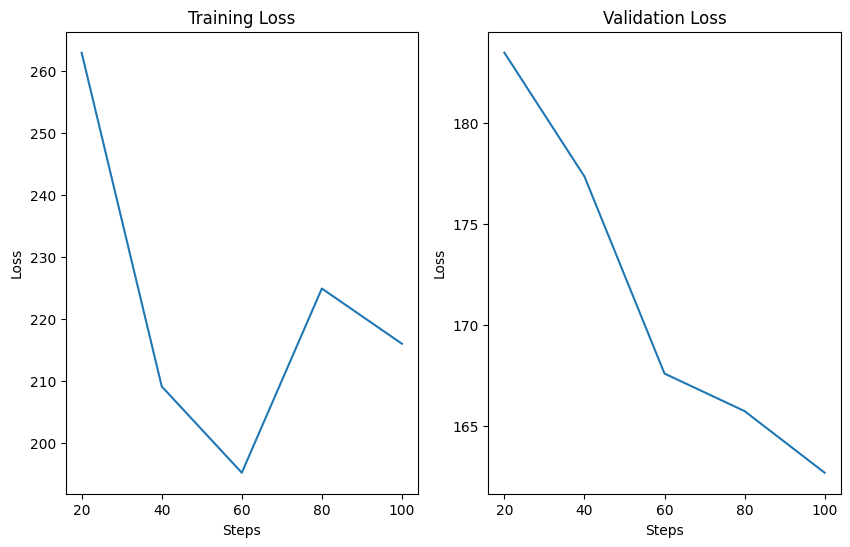

In [61]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,6))

axs[0].plot(train_loss_df["step"], train_loss_df["loss"])
axs[0].set_title("Training Loss")
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Loss')

axs[1].plot(eval_loss_df["step"], eval_loss_df["eval_loss"])
axs[1].set_title("Validation Loss")
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Loss')

Interpretation of Results:
- Validation loss OK, with loss decreasing over time
- Training loss generally decreasing, but could be better with slight increase then decrease over the halfway mark
- Do note training procedure was modified compared to original intentions due to computational resource limitations
- Ideally in expected model training, training and validation loss should converge over a long time  

# 4. Prediction

In [62]:
# saving the model
FT_ASR_MODEL = 'wav2vec2-large-960h-cv'
trainer_v2.save_model(FT_ASR_MODEL)

Saving model checkpoint to wav2vec2-large-960h-cv
Configuration saved in wav2vec2-large-960h-cv\config.json
Model weights saved in wav2vec2-large-960h-cv\pytorch_model.bin
Feature extractor saved in wav2vec2-large-960h-cv\preprocessor_config.json


In [64]:
from transformers import AutoModelForCTC

# loading for inference
ft_model = AutoModelForCTC.from_pretrained(FT_ASR_MODEL)

loading configuration file wav2vec2-large-960h-cv\config.json
Model config Wav2Vec2Config {
  "_name_or_path": "wav2vec2-large-960h-cv",
  "activation_dropout": 0.1,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "feat_qua

## 4.1. Processing Test Data
(Similar to Part 1 of Notebook) 

In [84]:
AUDIO_TEST_DIR = r"C:\Users\jared\Downloads\common_voice\cv-valid-test"
CSV_TEST_FILE = r"C:\Users\jared\Downloads\common_voice\cv-valid-test.csv"

In [85]:
test_data_df = pd.read_csv(CSV_TEST_FILE)
test_data_df

filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  up_votes  down_votes  \
0            without the dataset the article is useless         1           0   
1                                 i've got to go to him         1           0   
2                                       and you know it         1           0   
3     down below in the darkness were hundreds of pe...         4           0   
4     hold your nose to keep the smell from disablin...         2           0   
...                                                 ...       ...         ...   
3990  the old man opened his cape and the boy was st...         1           0   
3991       in alchemy it's called the soul of the world         2           1   
3992  at that point in their lives everything is cle...         3           0   
3993                      he told them all to be seated         3           0   
3994                 the restaurant was quite expensive         2           0   

           age gender accent  duration  
0          NaN    NaN    NaN       NaN  
1     twenties   male    NaN       NaN  
2          NaN    NaN    NaN       NaN  
3     twenties   male     us       NaN  
4          NaN    NaN    NaN       NaN  
...        ...    ...    ...       ...  
3990       NaN    NaN    NaN       NaN  
3991       NaN    NaN    NaN       NaN  
3992       NaN    NaN    NaN       NaN  
3993       NaN    NaN    NaN       NaN  
3994       NaN    NaN    NaN       NaN  

[3995 rows x 8 columns]

In [86]:
# Create an empty dataframe
test_df = pd.DataFrame() 
test_df["filename"] = test_data_df["filename"]
test_df["text"] = test_data_df["text"]
test_df

filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  
0            without the dataset the article is useless  
1                                 i've got to go to him  
2                                       and you know it  
3     down below in the darkness were hundreds of pe...  
4     hold your nose to keep the smell from disablin...  
...                                                 ...  
3990  the old man opened his cape and the boy was st...  
3991       in alchemy it's called the soul of the world  
3992  at that point in their lives everything is cle...  
3993                      he told them all to be seated  
3994                 the restaurant was quite expensive  

[3995 rows x 2 columns]

In [87]:
# assuming whole notebook is run in one instance, calling functions from Part 1 here
test_df['audio'] = test_df['filename'].map(lambda x: preprocess_audio(AUDIO_TEST_DIR, x))
test_df

C:\Users\jared\Downloads\common_voice\cv-valid-test
cv-valid-test/sample-000000.mp3
Loading audio from: C:\Users\jared\Downloads\common_voice\cv-valid-test\cv-valid-test/sample-000000.mp3
[ 3.8050308e-23 -3.7223128e-24  0.0000000e+00 ...  2.0281236e-06
  1.9477056e-07  3.8479739e-06]
16000
C:\Users\jared\Downloads\common_voice\cv-valid-test
cv-valid-test/sample-000001.mp3
Loading audio from: C:\Users\jared\Downloads\common_voice\cv-valid-test\cv-valid-test/sample-000001.mp3
[ 8.1854523e-12 -1.8189894e-11 -2.9103830e-11 ...  2.1212036e-05
 -1.2093107e-05 -2.1796674e-05]
16000
C:\Users\jared\Downloads\common_voice\cv-valid-test
cv-valid-test/sample-000002.mp3
Loading audio from: C:\Users\jared\Downloads\common_voice\cv-valid-test\cv-valid-test/sample-000002.mp3
[ 4.3655746e-11  5.0931703e-11 -1.1641532e-10 ... -6.2168227e-04
 -5.5417768e-05 -4.3233915e-04]
16000
C:\Users\jared\Downloads\common_voice\cv-valid-test
cv-valid-test/sample-000003.mp3
Loading audio from: C:\Users\jared\Download

filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  \
0            without the dataset the article is useless   
1                                 i've got to go to him   
2                                       and you know it   
3     down below in the darkness were hundreds of pe...   
4     hold your nose to keep the smell from disablin...   
...                                                 ...   
3990  the old man opened his cape and the boy was st...   
3991       in alchemy it's called the soul of the world   
3992  at that point in their lives everything is cle...   
3993                      he told them all to be seated   
3994                 the restaurant was quite expensive   

                                                  audio  
0     [3.8050308e-23, -3.7223128e-24, 0.0, -3.825710...  
1     [8.185452e-12, -1.8189894e-11, -2.910383e-11, ...  
2     [4.3655746e-11, 5.0931703e-11, -1.1641532e-10,...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [1.0913936e-11, -1.8189894e-12, -1.8189894e-12...  
...                                                 ...  
3990  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3991  [4.7433845e-20, -8.944668e-19, -3.5575384e-19,...  
3992  [5.820766e-10, -2.6193447e-10, -5.820766e-10, ...  
3993  [5.684342e-14, -9.379164e-13, -6.536993e-13, 5...  
3994  [-1.0913936e-11, -2.6375346e-11, 5.456968e-12,...  

[3995 rows x 3 columns]

In [89]:
# Convert the pandas DataFrame to a Hugging Face Dataset
test_ds = Dataset.from_pandas(test_df) 
test_ds = test_ds.map(remove_special_characters)
test_ds = test_ds.map(prepare_dataset) 
test_ds

Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

C:\Users\jared\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Dataset({
    features: ['filename', 'text', 'audio', 'input_values', 'labels'],
    num_rows: 3995
})

# 4.2. Inference

In [90]:
# Put the model in evaluation mode
ft_model.eval() 

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [93]:
def inference_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"]).unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch

In [94]:
test_results = test_ds.map(inference_result)
test_results

Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

Dataset({
    features: ['filename', 'text', 'audio', 'input_values', 'labels', 'pred_str'],
    num_rows: 3995
})

In [97]:
idx = 53
print(f"Text: {test_results[idx]['text']}")
print(f"Prediction: {test_results[idx]['pred_str']}") 

Text: OF COURSE THE TWO WERE UNABLE TO DO ANYTHING
Prediction: OF COURSE THE TWO WERE UNABLE TO DO ANYTHING


In [99]:
selected_columns = ['filename', 'text', 'pred_str']

all_results_df = test_results.to_pandas() 
results_df = all_results_df[selected_columns]
results_df

filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  \
0            WITHOUT THE DATASET THE ARTICLE IS USELESS   
1                                 I'VE GOT TO GO TO HIM   
2                                       AND YOU KNOW IT   
3     DOWN BELOW IN THE DARKNESS WERE HUNDREDS OF PE...   
4     HOLD YOUR NOSE TO KEEP THE SMELL FROM DISABLIN...   
...                                                 ...   
3990  THE OLD MAN OPENED HIS CAPE AND THE BOY WAS ST...   
3991       IN ALCHEMY IT'S CALLED THE SOUL OF THE WORLD   
3992  AT THAT POINT IN THEIR LIVES EVERYTHING IS CLE...   
3993                      HE TOLD THEM ALL TO BE SEATED   
3994                 THE RESTAURANT WAS QUITE EXPENSIVE   

                                               pred_str  
0           WITHOUT THE DAT ASS ET THE ARTICLES USELESS  
1                                 I'VE GAT TO GO TO HIM  
2                                       AND YOU KNOW IT  
3     DOWN BELOW IN THE DARKNESS WERE HUNDREDS OF PE...  
4     HOLD YOUR NOSE TO KEEP THE SMELL FROM DISABLIN...  
...                                                 ...  
3990  THE OLD MAN OPENED HIS CAPE AND THE BOY WAS ST...  
3991       AN ARCHIME HADS CAUGHT THE SOUL OF THE WORLD  
3992  AT THAT POINT IN THEIR LIVES EVERYTHING IS CLE...  
3993                      HE TOLD THEM ALL TO BE SEATED  
3994                 THE RESTAURENT WAS QUITE EXPENSIVE  

[3995 rows x 3 columns]

In [100]:
results_df.to_csv("test_results.csv")

# 4.3. Results Processing

In [101]:
# Calculate WER for each row
results_df['wer'] = results_df.apply(lambda row: wer_metric.compute(predictions=[row['pred_str']], 
                                                                    references=[row['text']]), 
                                                                    axis=1) 

results_df

C:\Users\jared\AppData\Local\Temp\ipykernel_10332\758498177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['wer'] = results_df.apply(lambda row: wer_metric.compute(predictions=[row['pred_str']],


filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  \
0            WITHOUT THE DATASET THE ARTICLE IS USELESS   
1                                 I'VE GOT TO GO TO HIM   
2                                       AND YOU KNOW IT   
3     DOWN BELOW IN THE DARKNESS WERE HUNDREDS OF PE...   
4     HOLD YOUR NOSE TO KEEP THE SMELL FROM DISABLIN...   
...                                                 ...   
3990  THE OLD MAN OPENED HIS CAPE AND THE BOY WAS ST...   
3991       IN ALCHEMY IT'S CALLED THE SOUL OF THE WORLD   
3992  AT THAT POINT IN THEIR LIVES EVERYTHING IS CLE...   
3993                      HE TOLD THEM ALL TO BE SEATED   
3994                 THE RESTAURANT WAS QUITE EXPENSIVE   

                                               pred_str       wer  
0           WITHOUT THE DAT ASS ET THE ARTICLES USELESS  0.714286  
1                                 I'VE GAT TO GO TO HIM  0.166667  
2                                       AND YOU KNOW IT  0.000000  
3     DOWN BELOW IN THE DARKNESS WERE HUNDREDS OF PE...  0.000000  
4     HOLD YOUR NOSE TO KEEP THE SMELL FROM DISABLIN...  0.083333  
...                                                 ...       ...  
3990  THE OLD MAN OPENED HIS CAPE AND THE BOY WAS ST...  0.000000  
3991       AN ARCHIME HADS CAUGHT THE SOUL OF THE WORLD  0.444444  
3992  AT THAT POINT IN THEIR LIVES EVERYTHING IS CLE...  0.000000  
3993                      HE TOLD THEM ALL TO BE SEATED  0.000000  
3994                 THE RESTAURENT WAS QUITE EXPENSIVE  0.200000  

[3995 rows x 4 columns]

2 forms of analysis are used, qualitiative and quantitative:
1. Quantitative - using WER metric on results
2. Qualitiative - manual inspection of outputs

## 4.3.1. Quantiative

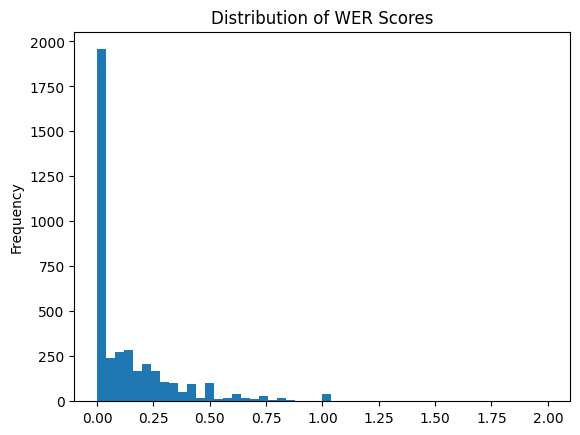

In [102]:
# Plot the distribution of WER scores
results_df['wer'].plot.hist(bins=50, title="Distribution of WER Scores", xlabel="WER", ylabel="Frequency") 

# Show the plot
plt.show() 

In [113]:
# Get descriptive statistics for the 'wer' column
wer_stats = results_df['wer'].describe()
wer_stats

count    3995.000000
mean        0.137106
std         0.205480
min         0.000000
25%         0.000000
50%         0.062500
75%         0.200000
max         2.000000
Name: wer, dtype: float64

Observations:
- (Bar chart) Knowing WER scores are the lower the better, it is observed from the above distributions that the scores skew to the left, aka towards 0, which shows a decent performance by the ASR
- (Bar chart) Notably, a significant portion of records are in the lowest bin towards 0, showing the model has performed well in the transcription prediction task 
- Also from WER statistics, it acts as supporting evidence that the distribution is skewed to the left: with the mean being 0.13, the 50-percentile being 0.06 (< 0.1), and 75-percentile being 0.20; these support that the model has performed well in the transcription prediction task

## 4.3.2. Qualitative

Given large dataset output, Qualitative analysis is done via random sampling.

In [112]:
# Get the number of rows in the DataFrame
num_rows = len(results_df)

# Define the number of rows to select
num_samples = 10  

# Create a list of random indices
random_indices = random.sample(range(num_rows), num_samples)

# Select the random rows from the DataFrame
random_rows_df = results_df.iloc[random_indices]

# Print the selected rows
random_rows_df

filename  \
2413  cv-valid-test/sample-002413.mp3   
1139  cv-valid-test/sample-001139.mp3   
3315  cv-valid-test/sample-003315.mp3   
3560  cv-valid-test/sample-003560.mp3   
26    cv-valid-test/sample-000026.mp3   
3108  cv-valid-test/sample-003108.mp3   
3300  cv-valid-test/sample-003300.mp3   
653   cv-valid-test/sample-000653.mp3   
2859  cv-valid-test/sample-002859.mp3   
1731  cv-valid-test/sample-001731.mp3   

                                                   text  \
2413    IT SORT OF MAKES A FELLOW LOSE FAITH IN HIMSELF   
1139                    WHAT AM I GOING TO SAY TO ELVIS   
3315                  THE TRAIN PULLED INTO THE STATION   
3560  HE HAD FOUND WHERE HIS TREASURE WAS AND WAS FR...   
26                        YOU'LL TAKE FIFTY AND LIKE IT   
3108                           MY CHINCHILLA EATS BREAD   
3300  HE FOLLOWED THE MOVEMENT OF THE BIRDS TRYING T...   
653   HE SHOULD HAVE DECIDED TO BECOME A SHEPHERD TH...   
2859                             ANY TIME BUT CHRISTMAS   
1731  BUT HE KEPT QUIET BECAUSE HE HAD HEARD WHAT TH...   

                                               pred_str       wer  
2413    IT SORT OF MAKES A FELLOW LOSE FAITH IN HIMSELF  0.000000  
1139                    WHAT AM I GOING TO SAY TO ALVIS  0.125000  
3315                  THE TRAIN PULLED INTO THE STATION  0.000000  
3560  HE HAD FOUND WHERE HIS TREASURE WAS AND WAS FR...  0.000000  
26                        YOU'LL TAKE FIFTY AND LIKE IT  0.000000  
3108                            MICHINCHILLA EATS BREAD  0.500000  
3300  HE FOLLOWED THE MOVEMENT OF THE BIRDS TRYING T...  0.000000  
653   HE SHOULD HAVE DECIDED TO BECOME A SHEPHERD TH...  0.000000  
2859                             ANY TIME BUT CHRISTMAS  0.000000  
1731  BUT HE KEPT QUIET BECAUSE HE HAD HEARD WHAT TH...  0.066667

Observations:
- Randomly sampled records look very decent, with a handful being exact matches
- Otherwise they contain mild differences, eg 'ELVIS' vs 'ALVIS' (Row number 1139)